In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib

matplotlib.rcParams['figure.figsize'] = (8, 3.5)
sns.set()
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv('../data/diabetic_data.csv')
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


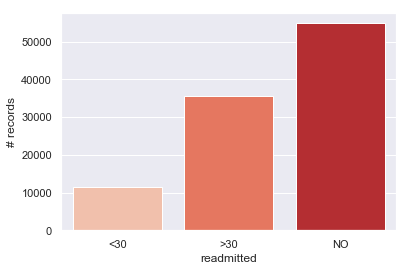

In [3]:
sns.barplot(data=df.groupby(['readmitted']).agg({'encounter_id': 'count'}).reset_index().rename(columns={'encounter_id': '# records'}), x='readmitted', y='# records', palette='Reds') 

In [4]:
df.drop_duplicates('patient_nbr').groupby(['readmitted']).agg({'encounter_id': 'count'}).reset_index().rename(columns={'encounter_id': '# records'})

,readmitted,# records
0,<30,6293
1,>30,22240
2,NO,42985


### Choosing Treatments

In [5]:
df['no_med'] = 'No'
MED_COLUMNS = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone' , 'no_med']
df.loc[:, MED_COLUMNS] = df[MED_COLUMNS].where(df[MED_COLUMNS] == 'No', 1)
df.loc[:, MED_COLUMNS] = df[MED_COLUMNS].where(df[MED_COLUMNS] == 1, 0)
df.loc[:, MED_COLUMNS] = df.loc[:, MED_COLUMNS].astype(int)
df['n_d_meds'] = df[MED_COLUMNS].sum(axis=1).astype(int)
df['no_med'] = (df['n_d_meds'] == 0) * 1
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,no_med,n_d_meds
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,NO,1,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,>30,0,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,Yes,NO,0,1
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,NO,0,1
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,NO,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,>30,0,2
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No,Yes,NO,0,1
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,NO,0,2
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,NO,0,3


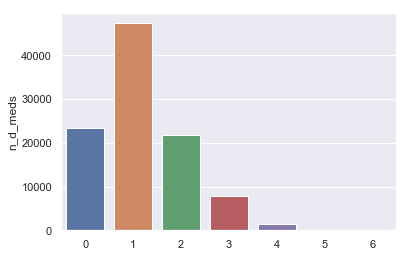

In [6]:
s0 = df['n_d_meds'].value_counts()
sns.barplot(x=s0.index, y=s0)

In [7]:
df[(df['metformin'] > 0) & (df['insulin'] > 0)].shape

(10012, 52)

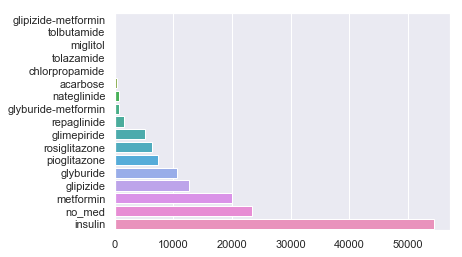

In [8]:
s1 = df[MED_COLUMNS].sum(axis=0).sort_values()
s1 = s1[s1 > 10]
sns.barplot(x=s1, y=s1.index)

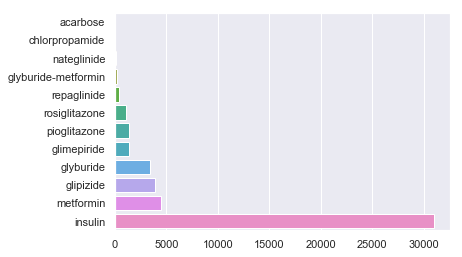

In [9]:
s2 = df[df['n_d_meds'] == 1][MED_COLUMNS].sum(axis=0).sort_values()
s2 = s2[s2 > 20]
sns.barplot(x=s2, y=s2.index)

In [10]:
can_meds = ['glyburide','glipizide','metformin','insulin']
results = []
df_no_med = df
results.append(df_no_med[can_meds].sum(axis=0))
results.append(df_no_med[df_no_med['n_d_meds'] <= 1][can_meds].sum(axis=0))
results.append(df_no_med[df_no_med['n_d_meds'] <= 2][can_meds].sum(axis=0))
results = pd.DataFrame(results).astype(int)
results.index = ['No constraints', 'Exactly 1', '2 or less than']
results

,glyburide,glipizide,metformin,insulin
No constraints,10650,12686,19988,54383
Exactly 1,3374,3868,4484,30965
2 or less than,7847,9344,13205,46402


In [11]:
df[df['n_d_meds'] == 1][can_meds].sum(axis=0)

glyburide     3374
glipizide     3868
metformin     4484
insulin      30965
dtype: int64

In [12]:
patients = df[['patient_nbr']+MED_COLUMNS].groupby('patient_nbr').mean().reset_index()
patients_insulin_and_metformin = patients[(patients['insulin'] > 0) & (patients['metformin'] > 0)]['patient_nbr'].unique().tolist()
print(len(patients_insulin_and_metformin))

9103


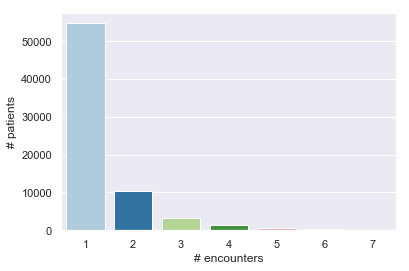

In [13]:
s0 = df.groupby('patient_nbr').agg({'encounter_id':'count'}).reset_index().rename(columns={'encounter_id':'# encounters'}).groupby('# encounters').agg({'patient_nbr':'nunique'}).reset_index().rename(columns={'patient_nbr':'# patients'})
s0 = s0[s0['# encounters'] < 8]
sns.barplot(x=s0['# encounters'], y=s0['# patients'], palette='Paired')

### Filtering The Data

In [14]:
CATEGORICAL_COLUMNS = ['race', 'gender', 'age',  'max_glu_serum', 'A1Cresult', 'readmitted']
df = df[(df['n_d_meds'] <= 2) & (df['patient_nbr'].isin(patients_insulin_and_metformin) == False) &
        (df['glyburide-metformin'] + df['glipizide-metformin'] + df['glimepiride-pioglitazone'] + 
         df['metformin-rosiglitazone'] + df['metformin-pioglitazone'] == 0)]
df['number_visits'] = df['number_outpatient'] + df['number_inpatient']
df['num_procedures'] = df['num_lab_procedures'] + df['num_procedures']
df['treatment'] = 'other'
df.loc[(df['insulin'] == False) & (df['metformin'] == True), 'treatment'] = 'metformin'
df.loc[(df['insulin'] == True) & (df['metformin'] == False), 'treatment'] = 'insulin'
df2 = pd.get_dummies(df[['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'time_in_hospital', 'num_procedures',
   'num_medications', 'number_visits', 'number_emergency', 'number_diagnoses',
    'max_glu_serum', 'A1Cresult', 'readmitted', 'treatment'] + MED_COLUMNS], prefix_sep=':', columns=CATEGORICAL_COLUMNS)

C:\python\conda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\python\conda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\python\conda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guid

In [15]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_procedures',
       'num_medications', 'number_visits', 'number_emergency',
       'number_diagnoses', 'treatment', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'no_med', 'race:?',
       'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic',
       'race:Other', 'gender:Female', 'gender:Male', 'gender:Unknown/Invalid',
       'age:[0-10)', 'age:[10-20)', 'age:[20-30)', 'age:[30-40)',
       'age:[40-50)', 'age:[50-60)', 'age:[60-70)', 'age:[70-80)',
       'age:[80-90)', 'age:[90-100)', 'max_glu_serum:>200',
       'max_glu_serum:

In [16]:
# df2.to_csv('../data/casual_diabetes.csv', index=False)

In [17]:
df2 = df2[df2['treatment'] != 'other']

In [18]:
ins = df2[df2['treatment'] == 'insulin']
met = df2[df2['treatment'] == 'metformin']
for col in ['time_in_hospital', 'num_procedures','num_medications', 'number_visits', 'number_emergency','number_diagnoses']:
    print(col)
    print(df2['insulin'].corr(df2[col]))
    print(df2['readmitted:<30'].corr(df2[col]))
    print(ins['readmitted:<30'].corr(ins[col]))
    print(met['readmitted:<30'].corr(met[col]))

time_in_hospital
0.0810816838887947
0.03505931167818696
0.02869867059969149
0.0474027597472755
num_procedures
0.10900945138284081
0.015655344191657563
0.005374105450778646
0.041297679889322966
num_medications
0.08745799710412618
0.03839613467131151
0.033948297882363296
0.0348453803209665
number_visits
0.08055777027440161
0.1406760746653771
0.14028778945285067
0.10952067855135854
number_emergency
0.03558561017034025
0.06078332992350966
0.057615204308948426
0.0811068679480192
number_diagnoses
0.12769522039793796
0.042808212292994134
0.036762284121644714
0.03618902279564887


### First Results 

In [19]:
means = df2.groupby('treatment').mean()

In [20]:
means[['age:[0-10)', 'age:[10-20)', 'age:[20-30)', 'age:[30-40)', 'age:[40-50)',
       'age:[50-60)', 'age:[60-70)', 'age:[70-80)', 'age:[80-90)', 'age:[90-100)']]

,age:[0-10),age:[10-20),age:[20-30),age:[30-40),age:[40-50),age:[50-60),age:[60-70),age:[70-80),age:[80-90),age:[90-100)
treatment,,,,,,,,,,
insulin,0.003421,0.013941,0.027599,0.045218,0.097227,0.162894,0.214672,0.240136,0.166804,0.028088
metformin,0.000000,0.001340,0.007503,0.036710,0.103162,0.199357,0.262862,0.262594,0.117899,0.008574


In [21]:
df2 = df2[df2['age:[0-10)'] == 0]
means = df2.groupby('treatment').mean()

In [22]:
means[['race:?',
       'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic',
       'race:Other', 'gender:Female', 'gender:Male']]

,race:?,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,gender:Female,gender:Male
treatment,,,,,,,,
insulin,0.026455,0.212595,0.006117,0.720041,0.018609,0.016183,0.538624,0.461376
metformin,0.021838,0.158360,0.006699,0.776527,0.021704,0.014871,0.541131,0.458735


In [23]:
means[['time_in_hospital', 'num_procedures',
       'num_medications', 'number_visits', 'number_emergency',
       'number_diagnoses']]

,time_in_hospital,num_procedures,num_medications,number_visits,number_emergency,number_diagnoses
treatment,,,,,,
insulin,4.646380,46.569106,17.137127,1.116738,0.234946,7.607743
metformin,3.968783,40.558816,15.130359,0.681940,0.134244,6.909968


In [24]:
means[['max_glu_serum:>200', 'max_glu_serum:>300',
       'max_glu_serum:None', 'max_glu_serum:Norm', 'A1Cresult:>7',
       'A1Cresult:>8', 'A1Cresult:None', 'A1Cresult:Norm']]

,max_glu_serum:>200,max_glu_serum:>300,max_glu_serum:None,max_glu_serum:Norm,A1Cresult:>7,A1Cresult:>8,A1Cresult:None,A1Cresult:Norm
treatment,,,,,,,,
insulin,0.018377,0.017189,0.944199,0.020235,0.037140,0.103394,0.810040,0.049426
metformin,0.009780,0.005627,0.962353,0.022240,0.043944,0.071409,0.836683,0.047964


In [25]:
means[['metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', ]]

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide
treatment,,,,,,,,,
insulin,0.0,0.011201,0.004284,0.000413,0.034456,0.000026,0.078849,0.051129,0.000232
metformin,1.0,0.008039,0.004823,0.000268,0.046758,0.000000,0.137058,0.191586,0.000000


In [26]:
means[['pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin']]

,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin
treatment,,,,,,,,,
insulin,0.042251,0.033140,0.000748,0.000103,0.000026,0.000103,0.0,0.0,1.0
metformin,0.046758,0.055064,0.000670,0.000268,0.000000,0.000804,0.0,0.0,0.0


In [27]:
means[['readmitted:<30','readmitted:>30', 'readmitted:NO']]

,readmitted:<30,readmitted:>30,readmitted:NO
treatment,,,
insulin,0.121435,0.351916,0.526649
metformin,0.076367,0.277197,0.646436


### Propensity

In [28]:
from matplotlib import pyplot as plt

In [29]:
data = pd.read_csv('../data/casual_diabetes.csv')
treatments = (data[data['treatment'] != 'other']['treatment'] == 'insulin').to_numpy()
propensity_scores = pd.read_csv('../data/propensity_scores.csv')['0'].to_numpy()
print(treatments.shape, propensity_scores.shape)

(46342,) (46342,)


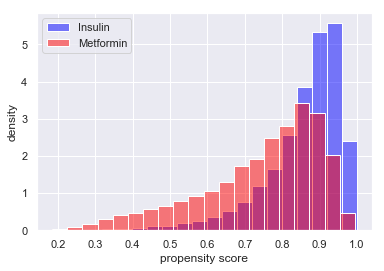

In [30]:
treat_plt = plt.hist(propensity_scores[treatments==1], fc=(0, 0, 1, 0.5),bins=20, label='Insulin', density=True)
cont_plt = plt.hist(propensity_scores[treatments==0],fc=(1, 0, 0, 0.5),bins=20, label='Metformin', density=True)
plt.legend();
plt.xlabel('propensity score');
plt.ylabel('density');